# Training Script to classify Chest XRay images into: pleural effusion/not pleural effusion

### Model: 
Resnet18 pretrained in Imagenet, 3 Channels as inputs, 1 output

##  Import libraries

In [1]:
import pandas as pd
from skimage.io import imread
from matplotlib import pyplot as plt
import time
import os
import copy
import cv2 
import numpy as np
from PIL import Image

# AI framework
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn as nn
import torchxrayvision as xrv

# Visualize the evolution of the model during training
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# Statistical analysis on the test dataset:
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {DEVICE}')

Device: cuda


## 1. Import data and pre-processing

## 1.1 Create a class to manage the dataset

In [2]:
# Define a personalized class for the dataset
class PadChestDataset(Dataset):
    
    def __init__(self, img_dir, csv_file, avail_imgID, transform = None):
        self.labels = pd.read_csv(csv_file, low_memory = False)
        
        # Replace missing values in "Labels" column with an empty string
        self.labels['Labels'].fillna('', inplace = True)
        
        # Filter by available image files
        self.labels = self.labels[self.labels["ImageID"].isin(avail_imgID)]
       
        # Create a dictionary to create binary labels: "normal": 1 and "others":0
        self.label_dict= {"not_pleural_effusion": 0, "pleural_effusion": 1}
        
        # Initializes instance variables img_dir and transform
        self.img_dir = img_dir
        self.transform = transform
        
    def normalize(self,image, rangeValues = (0, 1), dtype = np.float32):
        """
        Scales intensity values in the image to be within a specific range.

        :param image: input array
        :param rangeValue: minimum and maximum values defining the desired output range
        :param dtype: type of data for intensity value

        :return normalized image
        """
        image = np.array(image)
        image_norm = (image - np.min(image))/(np.max(image) - np.min(image)) # scale between zero and one
        image_norm = image_norm * (rangeValues[1] - rangeValues[0]) + rangeValues[0]
        return image_norm.astype(dtype)


    def equalize(self, image):    
        clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8,8))
        clahe_img = clahe.apply(image)

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15)) # MORPH_ELLIPSE
        eq_img = cv2.equalizeHist(image)
        tophat = cv2.morphologyEx(eq_img, cv2.MORPH_TOPHAT, kernel)
        bothat = cv2.morphologyEx(eq_img, cv2.MORPH_BLACKHAT, kernel)
        hat_img = eq_img + tophat - bothat

        return np.dstack((image, clahe_img, hat_img))
        

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        # Get labels: Map the csv labels to binary tags: 0 for normal or 1 for others
        csv_labels_name = self.labels['Labels'].iloc[idx]
        
        if 'pleural effusion' in csv_labels_name :
            labels = self.label_dict["pleural_effusion"]
        else:
            labels = self.label_dict["not_pleural_effusion"]
            
        # Get image paths
        imgid = self.labels['ImageID'].iloc[idx]
        img_path = os.path.join(self.img_dir, imgid)
     
        # Step 1: Load the image
        image_original = cv2.imread(img_path, cv2.IMREAD_UNCHANGED) 
        image_norm= self.normalize(image = image_original, rangeValues = (0, 255), dtype = np.uint8)

        # Step 2: Equalize
        image_eq = self.equalize(image_norm)
        img_trans = image_eq[...,::-1] # Invert the order of the channels

        # Step 3: Resize and transform to tensor   
        if self.transform:
            img_trans = self.transform(Image.fromarray(img_trans)).to(DEVICE)
            
        return img_trans, labels

## 1.2 Define the datasets and dataloaders

### Paths

In [3]:
# Define the paths
# Image paths
datapath = "/home/marialuque/datos_maria/Data/PadChest512_PA_Manually_Filtered"

# Labels path
csv_file = "/home/marialuque/datos_maria/Data/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv"

### Filter the images

In [4]:
# Train available image IDs
splitted_imageIDs_txtFiles = "split_individual_models_dataset/effusion_IDs"

train_imageIDs_available = os.path.join(splitted_imageIDs_txtFiles, "train_imageIDs.txt")
with open(train_imageIDs_available, "r") as f:
    train_avail_imgID = [line.strip() for line in f.readlines()]
    
# Valid available image IDs
valid_imageIDs_available = os.path.join(splitted_imageIDs_txtFiles, "valid_imageIDs.txt")
with open(valid_imageIDs_available, "r") as f:
    valid_avail_imgID = [line.strip() for line in f.readlines()]
    
# Test available image IDs
test_imageIDs_available = os.path.join(splitted_imageIDs_txtFiles, "test_imageIDs.txt")
with open(test_imageIDs_available, "r") as f:
    test_avail_imgID = [line.strip() for line in f.readlines()]

### Define the transforms

In [5]:
# Define the transforms
train_transform = transforms.Compose([
                            transforms.Resize((512,512)),
                            transforms.RandomRotation((-5, 5)),
                            transforms.RandomAffine(0, translate=(10/64, 10/64)),
                            transforms.ToTensor()
                            ])

valid_transform = transforms.Compose([
                            transforms.Resize((512,512)),
                            transforms.ToTensor()
                            ])

# Define the datasets and dataloaders
batch_size = 32

# Train
train_dataset = PadChestDataset(datapath, csv_file, train_avail_imgID, train_transform)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

# Valid
valid_dataset = PadChestDataset(datapath, csv_file, valid_avail_imgID, valid_transform)
valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = True)

#Test
test_dataset = PadChestDataset(datapath, csv_file, test_avail_imgID, valid_transform)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

# Datasets and Dataloader
datasets = {'train': train_dataset,'val': valid_dataset, 'test': test_dataset}
dataloaders = {'train': train_loader,'val': valid_loader,'test': test_loader}

In [6]:
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}
print("Train dataset size:",dataset_sizes['train'])
print("Valid dataset size:",dataset_sizes['val'])
print("Test dataset size:",dataset_sizes['test'])

Train dataset size: 5192
Valid dataset size: 577
Test dataset size: 641


## 2. Define the model, criterion and optimizer </h1>

### Resnet-18 TL

In [7]:
# Load the model pretrained in Covid-19 Dataset
model = models.resnet18(pretrained = True)
    
# Replace the FC layer with a classifier that has 1 class
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
model = model.to(DEVICE)

In [8]:
criterion = nn.BCEWithLogitsLoss(reduction='mean')
optim = torch.optim.SGD(model.parameters(), 0.001, weight_decay=0.0001, momentum=0.9)

## 3. Train the model

In [9]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                labels = labels.view(labels.size()[0],-1) #add for BCE loss

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    if isinstance(outputs, tuple):
                        outputs = outputs[0]
                        score = torch.sigmoid(outputs)
                    else:
                        score = torch.sigmoid(outputs)
                    preds = score>0.5
                    preds = preds.type(torch.cuda.LongTensor)
                
                    labels = labels.type(torch.cuda.FloatTensor) #add for BCE loss
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                writer.add_scalars('Loss', {'Loss/train': epoch_loss},epoch)
                writer.add_scalars('Accuracy',{'Accuracy/train':epoch_acc},epoch)

            
            elif phase == 'val':
                writer.add_scalars('Loss', {'Loss/val': epoch_loss},epoch)
                writer.add_scalars('Accuracy',{'Accuracy/val':epoch_acc},epoch)


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model, os.path.join('resnet18_pleural_effusion.pth'))
                print('Model saved!')

                

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    writer.flush()

In [10]:
train_model(model, dataloaders, criterion, optim, num_epochs = 25)

Epoch 0/24
----------
train Loss: 0.5336 Acc: 0.7390
val Loss: 0.3809 Acc: 0.8284
Model saved!
Epoch 1/24
----------
train Loss: 0.3870 Acc: 0.8328
val Loss: 0.3108 Acc: 0.8666
Model saved!
Epoch 2/24
----------
train Loss: 0.3174 Acc: 0.8733
val Loss: 0.2821 Acc: 0.8908
Model saved!
Epoch 3/24
----------
train Loss: 0.2740 Acc: 0.8958
val Loss: 0.2590 Acc: 0.9081
Model saved!
Epoch 4/24
----------
train Loss: 0.2449 Acc: 0.9076
val Loss: 0.2571 Acc: 0.9064
Epoch 5/24
----------
train Loss: 0.2220 Acc: 0.9122
val Loss: 0.2666 Acc: 0.8960
Epoch 6/24
----------
train Loss: 0.2075 Acc: 0.9203
val Loss: 0.2599 Acc: 0.9116
Model saved!
Epoch 7/24
----------
train Loss: 0.1840 Acc: 0.9322
val Loss: 0.2702 Acc: 0.9012
Epoch 8/24
----------
train Loss: 0.1628 Acc: 0.9407
val Loss: 0.3083 Acc: 0.8943
Epoch 9/24
----------
train Loss: 0.1356 Acc: 0.9492
val Loss: 0.3271 Acc: 0.8908
Epoch 10/24
----------
train Loss: 0.1124 Acc: 0.9572
val Loss: 0.3216 Acc: 0.8891
Epoch 11/24
----------
train Los

# Evaluation metrics

In [8]:
# Load model
model = torch.load(os.path.join('models','resnet18_pleural_effusion.pth'))
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
model.eval()
running_corrects = 0
output_list = []
label_list = []
preds_list = []
prob_list = []

with torch.no_grad():
        for data in test_loader:
            inputs, labels = data

            labels_auc = labels
            labels_print = labels
            labels_auc = labels_auc.type(torch.FloatTensor)
            labels = labels.type(torch.LongTensor) #add for BCE loss

            # wrap them in Variable
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            labels_auc = labels_auc.to(DEVICE)

            labels = labels.view(labels.size()[0],-1) #add for BCE loss
            labels_auc = labels_auc.view(labels_auc.size()[0],-1) #add for BCE loss
            # forward
            outputs = model(inputs)
            # _, preds = torch.max(outputs.data, 1)
            score = torch.sigmoid(outputs)
            score_np = score.data.cpu().numpy()
            preds = score>0.5
            preds_np = preds.data.cpu().numpy()
            preds = preds.type(torch.cuda.LongTensor)

            labels_auc = labels_auc.data.cpu().numpy()
            outputs = outputs.data.cpu().numpy()

            for i in range(outputs.shape[0]):
                output_list.append(outputs[i].tolist())
                prob_list.append(score_np[i].tolist())
                label_list.append(labels_auc[i].tolist())
                preds_list.append(preds_np[i].tolist())

            running_corrects += torch.sum(preds.data == labels.data) #add for BCE loss

### Statistics

In [10]:
# SHOW STATISTICS
acc = np.float(running_corrects) / dataset_sizes['test']
auc = metrics.roc_auc_score(np.array(label_list), np.array(output_list), average=None)

fpr, tpr, threshold = metrics.roc_curve(np.array(label_list), np.array(output_list))
roc_auc = metrics.auc(fpr, tpr)

ap = metrics.average_precision_score(np.array(label_list), np.array(output_list))

tn, fp, fn, tp = metrics.confusion_matrix(label_list, preds_list).ravel()

recall = tp/(tp+fn)
precision = tp/(tp+fp)
f1 = 2*precision*recall/(precision+recall)
sensitivity = recall
specificity = tn/(tn+fp)
PPV = tp/(tp+fp)
NPV = tn/(tn+fn)

print('Test Accuracy: {0:.4f}  Test AUC: {1:.4f}  Test_AP: {2:.4f}'.format(acc, auc, ap))
print('TP: {0:}  FP: {1:}  TN: {2:}  FN: {3:}'.format(tp, fp, tn, fn))
print('Sensitivity: {0:.4f}  Specificity: {1:.4f}'.format(sensitivity, specificity))
print('Precision: {0:.2f}%  Recall: {1:.2f}%  F1: {2:.4f}'.format(precision*100, recall*100, f1))
print('PPV: {0:.4f}  NPV: {1:.4f}'.format(PPV, NPV))

Test Accuracy: 0.8892  Test AUC: 0.9557  Test_AP: 0.9447
TP: 247  FP: 38  TN: 323  FN: 33
Sensitivity: 0.8821  Specificity: 0.8947
Precision: 86.67%  Recall: 88.21%  F1: 0.8743
PPV: 0.8667  NPV: 0.9073


### Classification report

In [12]:
from sklearn.metrics import classification_report
class_names = ["not pleural_effusion","pleural_effusion"]
print(classification_report(label_list, preds_list, target_names = class_names, digits = 4))

                      precision    recall  f1-score   support

not pleural_effusion     0.9073    0.8947    0.9010       361
    pleural_effusion     0.8667    0.8821    0.8743       280

            accuracy                         0.8892       641
           macro avg     0.8870    0.8884    0.8877       641
        weighted avg     0.8896    0.8892    0.8893       641



### Confusion Matrix

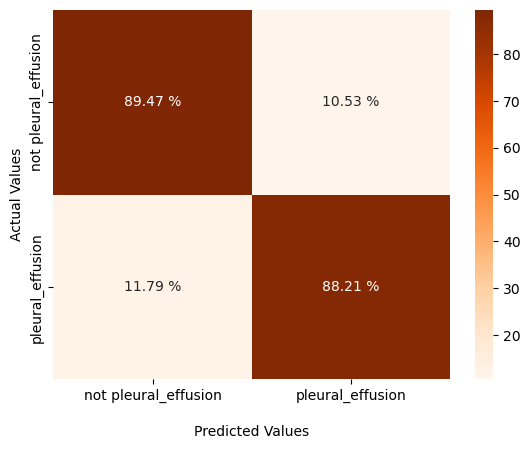

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
cmat = confusion_matrix(label_list, preds_list, normalize='true')

# Round the values in the confusion matrix
cmat_rounded = np.round(cmat, decimals=4)

# Create visualization
ax = sns.heatmap(cmat_rounded * 100, annot=True, cmap='Oranges', fmt='.2f')

for t in ax.texts:
    t.set_text(t.get_text() + " %")

# Set the axis labels
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')
ax.xaxis.set_ticklabels(['not pleural_effusion', 'pleural_effusion'])
ax.yaxis.set_ticklabels(['not pleural_effusion', 'pleural_effusion'])

# Show the plot
plt.show()


In [16]:
tn, fp, fn, tp  = confusion_matrix(label_list, preds_list).ravel()
print('True Negative(TN)=  %s\nFalse Positive(FP)= %s\nFalse Negative(FN)= %s\nTrue Positive(TP)=  %s' % (tn, fp, fn,tp))

True Negative(TN)=  323
False Positive(FP)= 38
False Negative(FN)= 33
True Positive(TP)=  247


### Plot ROC-Curve and calculate AUC

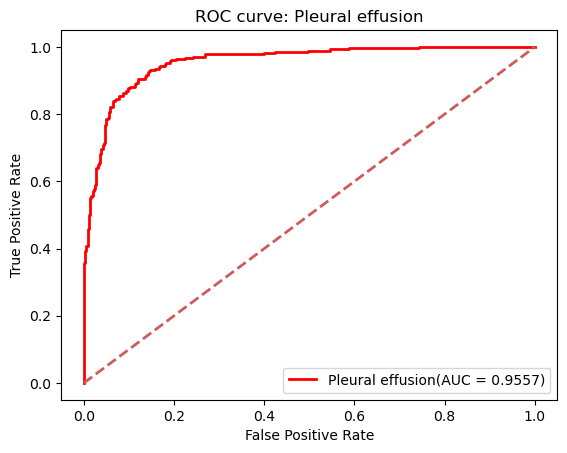

In [12]:
fpr, tpr, threshold = metrics.roc_curve(np.array(label_list), np.array(output_list))
#ROC CURVE
plt.figure()
plt.plot(fpr, tpr, lw=2, color='red', label='Pleural effusion (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='indianred', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: Pleural effusion')
plt.legend(loc="lower right")
plt.show()